In [7]:
import numpy as np
from data_loader import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure


import keras
from keras.layers import Input, Reshape, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Reshape, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout, Dense
from keras.models import Model
from keras.utils import plot_model, multi_gpu_model

In [8]:
data_file = "/datax/yzhang/training_data/training_data_chunk_0.pkl"
data = LoadModRecData(data_file, .9, .1, 0.)

test_file = "/datax/yzhang/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(test_file, 0.1, 0., 1.)



[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [9]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
number_of_samples_in_instance = data.instance_shape[1]
data.modTypes

array(['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB',
       'APSK16_c34', 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz',
       'FM_NB', 'FM_WB', 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK',
       'NOISE', 'OQPSK', 'PI4QPSK', 'QAM16', 'QAM32', 'QAM64', 'QPSK'],
      dtype='<U11')

(1, 1024) 1788
(1, 1024) 858
(1, 1024) 1293
(1, 1024) 1989
(1, 1024) 372
(1, 1024) 773
(1, 1024) 968
(1, 1024) 606
(1, 1024) 724
(1, 1024) 936
(1, 1024) 1462
(1, 1024) 31
(1, 1024) 544
(1, 1024) 1275
(1, 1024) 1628
(1, 1024) 903
(1, 1024) 1238
(1, 1024) 1988
(1, 1024) 504
(1, 1024) 1476
(1, 1024) 1806
(1, 1024) 376
(1, 1024) 313
(1, 1024) 1227


/home/morads/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


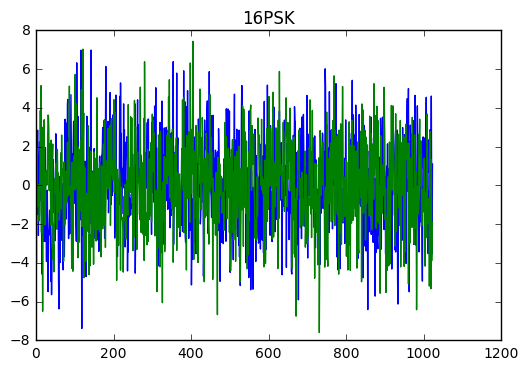

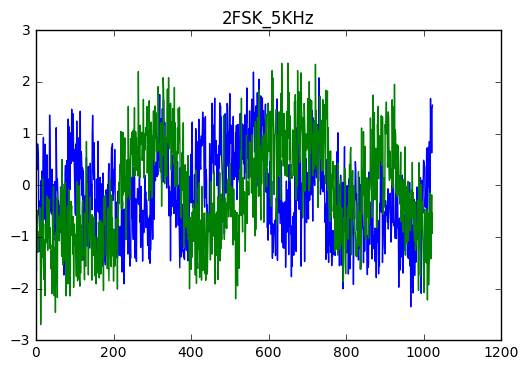

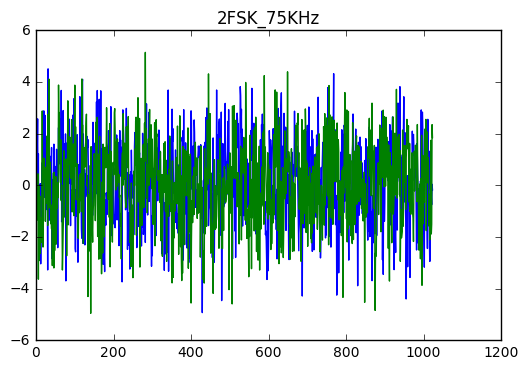

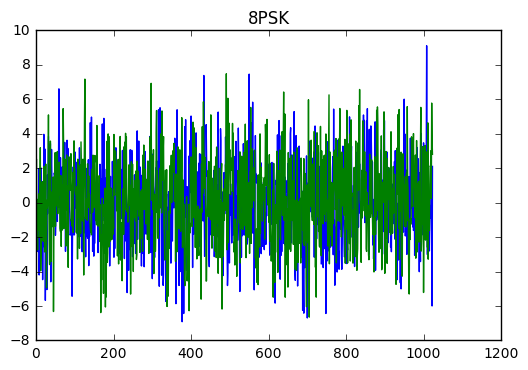

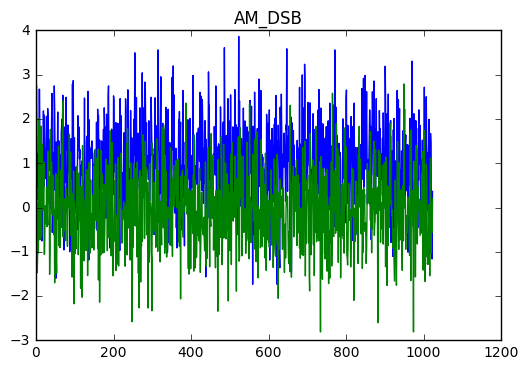

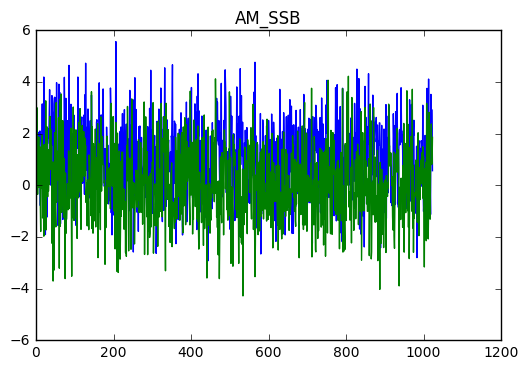

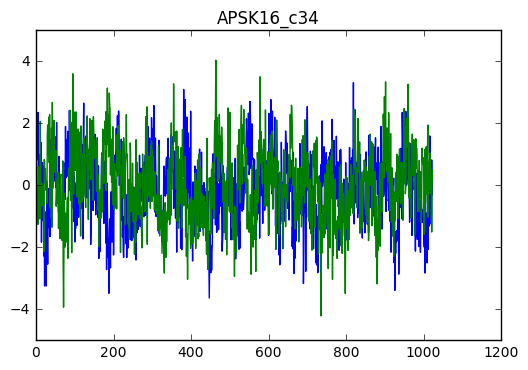

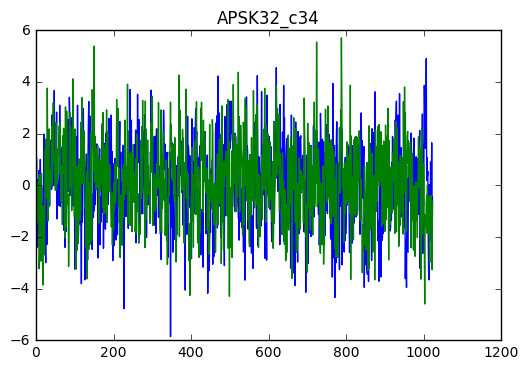

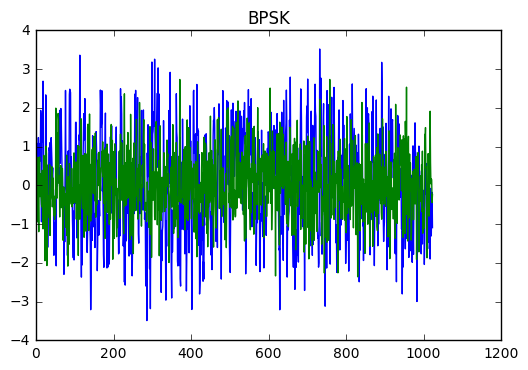

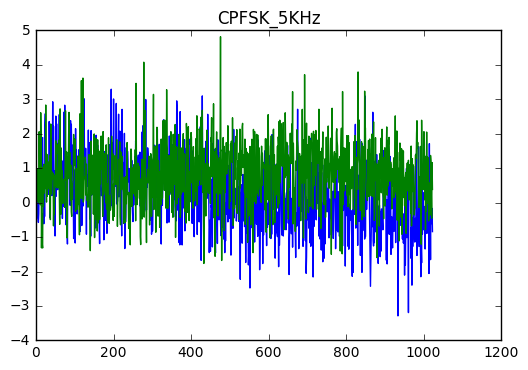

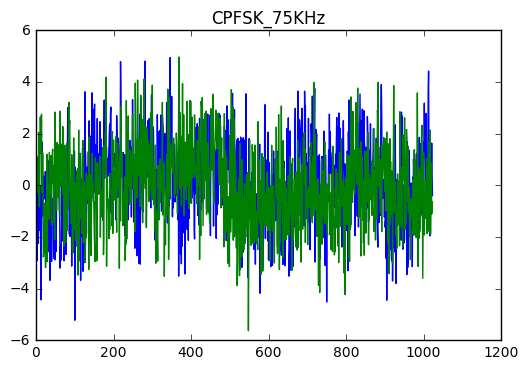

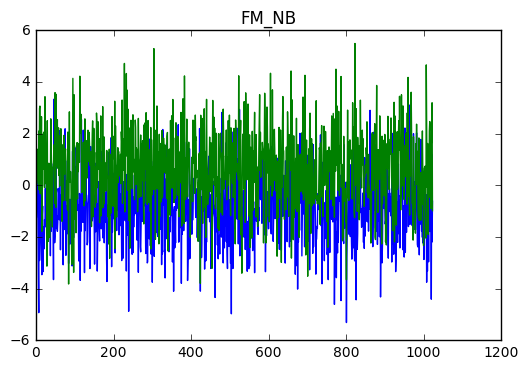

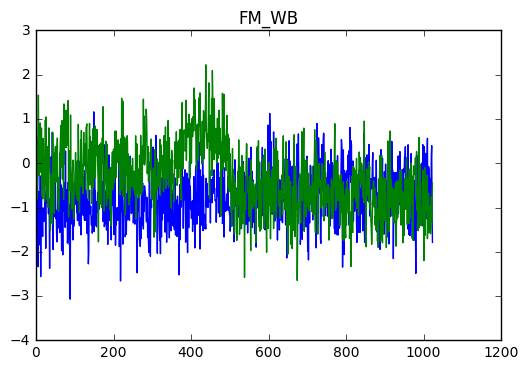

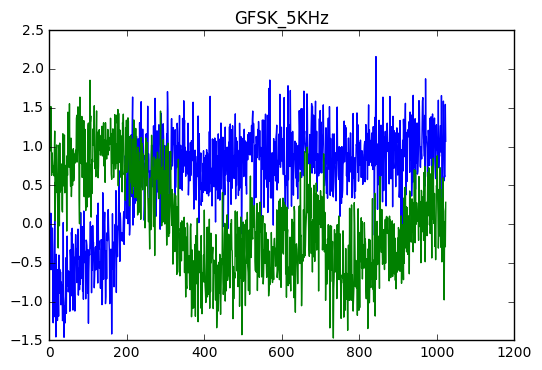

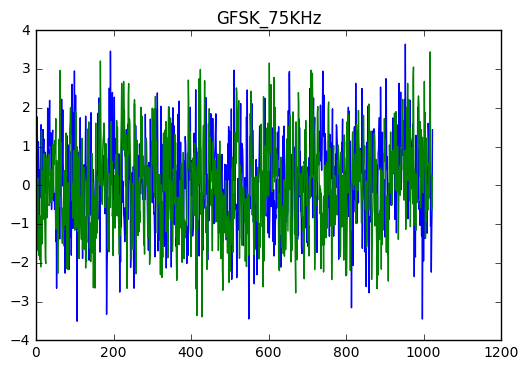

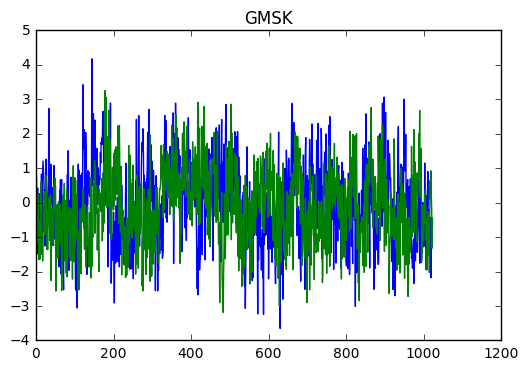

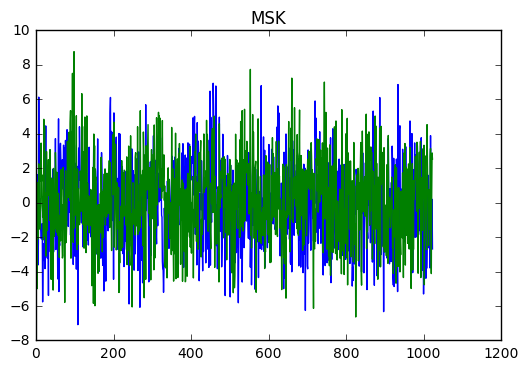

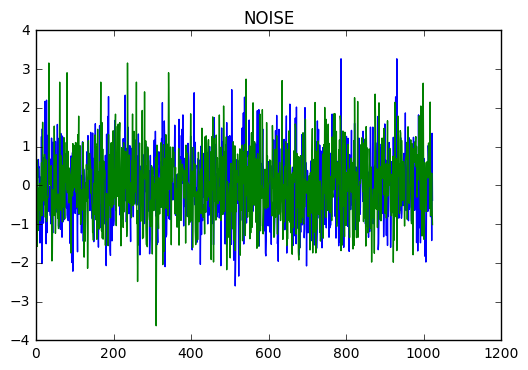

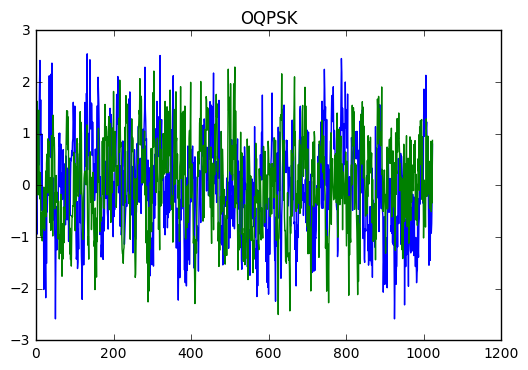

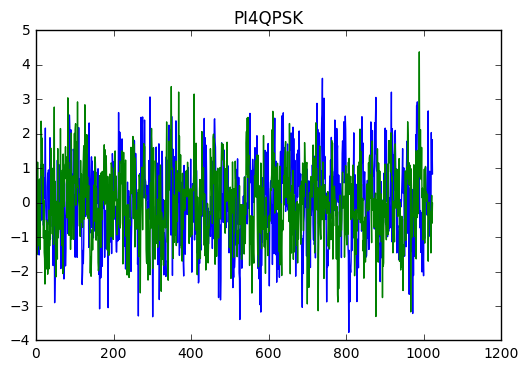

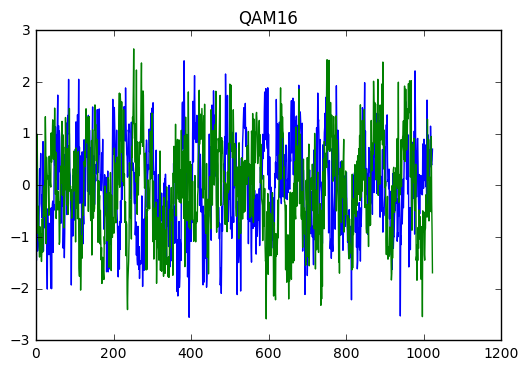

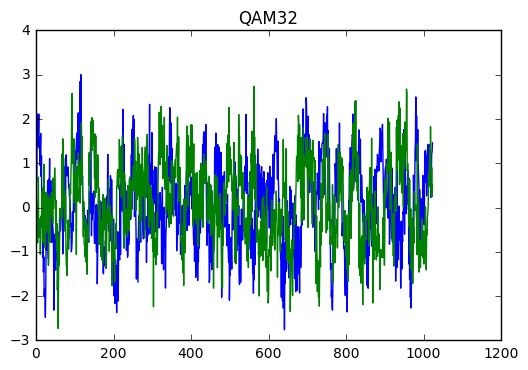

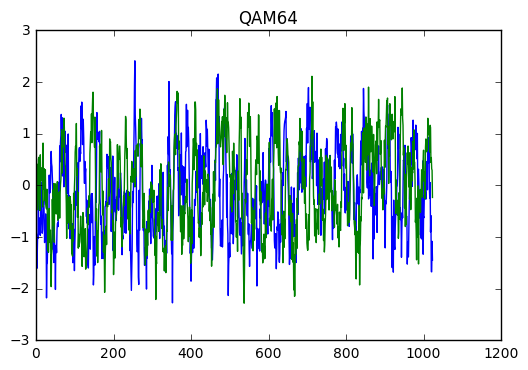

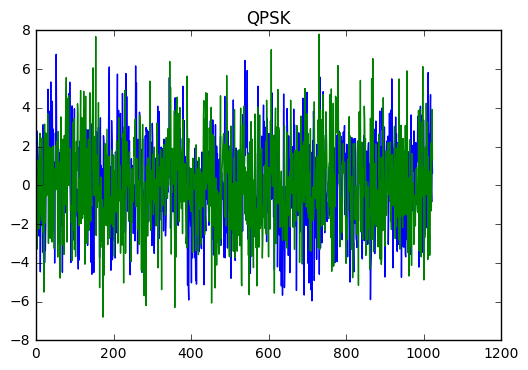

In [11]:
# for each modulation type, inspect some instances of data
for modType in data.modTypes[:]:
    min_SNR = -10
    max_SNR = 10
    snr_step = 4

    # get random snr within valid range
    snrValue = random.randrange(min_SNR, max_SNR, snr_step)

    # get a collection of signals
    collection_of_instances = data.dataCube[modType, snrValue]

    # get the complex samples for a specific instance within the collection
    cdata, index = get_complex_samples_for_instance(collection_of_instances)
    print(cdata.shape,index)

    # setup inspect
    sample_rate = number_of_samples_in_instance
    Ts = 1.0 / sample_rate
    t = np.arange(0, len(cdata[0])) * Ts
    
    plt.figure()
    plt.title(modType)
    plt.plot(cdata.squeeze().real)
    plt.plot(cdata.squeeze().imag)
    # inspect signal
plt.show()    #data.inspect_signal(index, modType, snrValue, cdata[0], t.tolist(), number_of_samples_in_instance, sample_rate, 0, True)

In [18]:
def inception(input_img, fs=[64,64,64,64,64], with_residual=False):
    tower_1 = Conv2D(filters=fs[0], kernel_size=1, padding='same', activation='relu')(input_img)
#     tower_1 = Conv2D(filters=fs[1], kernel_size=1, padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(filters=fs[2], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[3], kernel_size=3, padding='same', activation='relu')(tower_2)
    tower_3 = Conv2D(filters=fs[2], kernel_size=1, padding='same', activation='relu')(input_img)
    tower_3 = Conv2D(filters=fs[3], kernel_size=5, padding='same', activation='relu')(tower_3)
    tower_4 = MaxPooling2D(3, strides=1, padding='same')(input_img)
    tower_4 = Conv2D(filters=fs[4], kernel_size=1, padding='same', activation='relu')(tower_4)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis = 3)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output
def googleNet(x, data_format='channels_last'):
#     num_layers = [2,4,10,4]
    num_layers = [1,1,1,1]
    x = Reshape(in_shp + (1,), input_shape=in_shp)(x)
    x = Conv2D(filters = 64, kernel_size=[2,7], strides=[2,2], data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling2D([1, 3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[0]):
        x = Conv2D(filters = 192, kernel_size=[1, 3], strides=[1,1], padding='same', activation='relu')(x)
    x = MaxPooling2D([1,3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[1]):
        x = inception(x, fs=[32,64,32,64,64])
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[2]):
        x = inception(x, fs=[48,96,48,96,96], with_residual=True)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[3]):
        x = inception(x, fs=[32,64,32,64,64])
#     x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    output = Flatten()(x)
    out    = Dense(24, activation='softmax')(output)
    return out

in_shp = (2, 1024)
input_img = Input(shape=in_shp)
out = googleNet(input_img,data_format='channels_last')
model = Model(inputs=input_img, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 2, 1024)      0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 2, 1024, 1)   0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 1, 512, 64)   960         reshape_3[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 1, 256, 64)   0           conv2d_44[0][0]                  
__________________________________________________________________________________________________
conv2d_45 

In [19]:
plot_model(model, to_file='model.png', show_shapes = True)


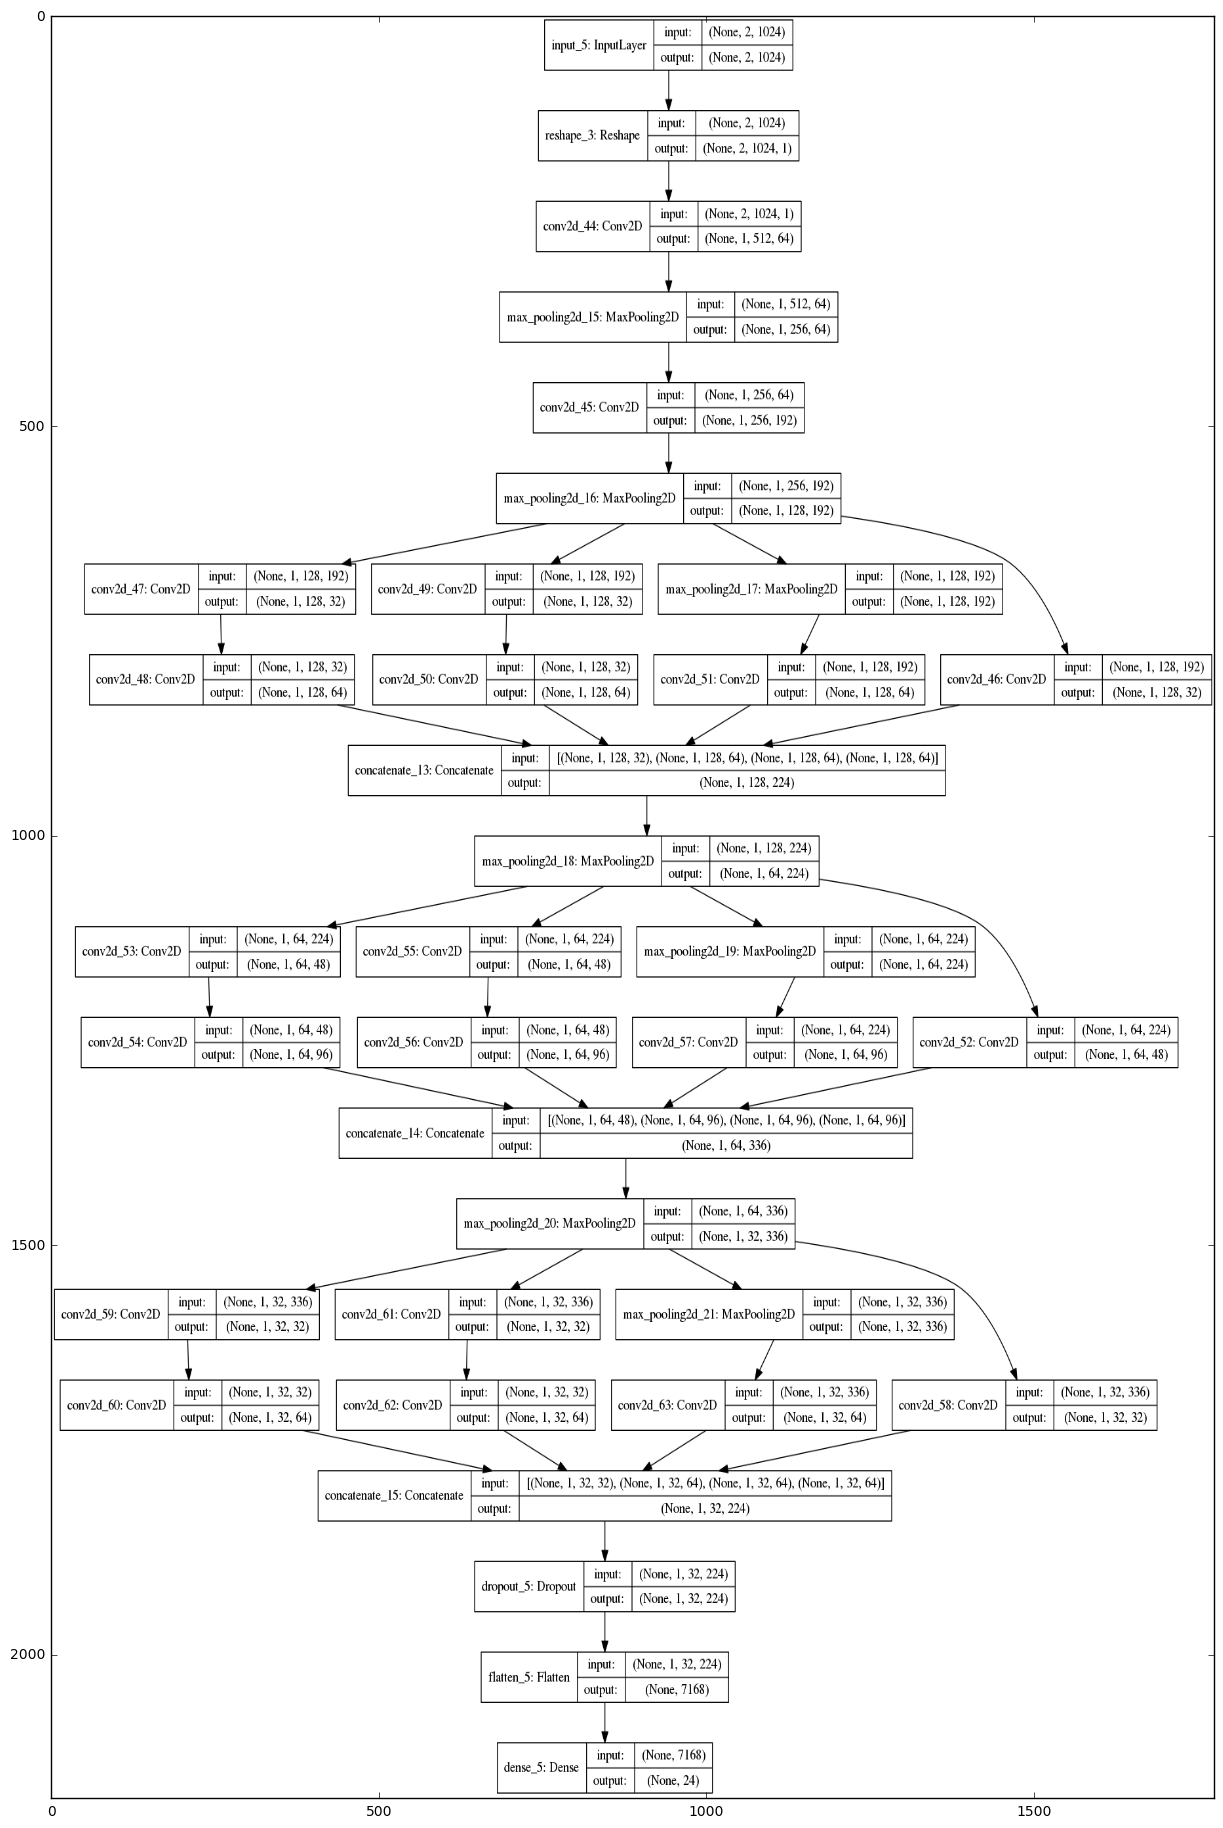

In [20]:
# Uncomment to visualize architecture

figure(figsize = (15,23))
img = mpimg.imread('model.png')
plt.imshow(img, aspect='auto')
plt.show()

In [ ]:
model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy', optimizer='adam')
filepath = '/tmp/morads/convmodrecnets_CNN2_0.5.wts.h5'
train_batch_size, number_of_epochs = 256, 40
tsteps = data.train_idx.size//train_batch_size
vsteps = data.val_idx.size//train_batch_size
train_batches = data.batch_iter(data.train_idx, train_batch_size, number_of_epochs, use_shuffle=True)
val_batches = data.batch_iter(data.val_idx, train_batch_size, number_of_epochs, use_shuffle=False)
# model.load_weights(filepath)
history = model.fit_generator(train_batches,
    nb_epoch=number_of_epochs,
    steps_per_epoch=tsteps,
    verbose=2,
    validation_data=val_batches,
    validation_steps=vsteps,
     callbacks = [
          keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss'    , verbose=0, save_best_only=True, mode='auto'),
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=5    , verbose=0, mode='auto')
     ]) 
model.save('mod_classifier17.h5')  



print("Done")

/home/morads/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/morads/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=40, verbose=2, steps_per_epoch=1012, callbacks=[<keras.ca..., validation_data=<generator..., validation_steps=112)`


Epoch 1/40
 - 25s - loss: 1.5340 - val_loss: 1.1785
Epoch 2/40
 - 23s - loss: 1.1597 - val_loss: 1.0662
Epoch 3/40
 - 23s - loss: 1.0570 - val_loss: 1.0279
Epoch 4/40


In [ ]:
# Plot confusion matrix
acc = {}
snrs = np.arange(-15,15, 5)

classes = testdata.modTypes

print("classes ", classes)
for snr in snrs:

    # extract classes @ SNR
    snrThreshold_lower = snr
    snrThreshold_upper = snr+5
    snr_bounded_test_indicies = testdata.get_indicies_withSNRthrehsold(testdata.test_idx, snrThreshold_lower, snrThreshold_upper)
    
    test_X_i = testdata.signalData[snr_bounded_test_indicies]
    test_Y_i = testdata.oneHotLabels[snr_bounded_test_indicies]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR", snr, "Overall Accuracy: ", cor / (cor+ncor), "Out of", len(snr_bounded_test_indicies))
    acc[snr] = 1.0*cor/(cor+ncor)